In [114]:
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

In [46]:
nyc_data = pd.read_csv('nyc_taxi_trip_duration.csv')
nyc_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


In [47]:
nyc_data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,729322.000000,729322.000000,729322.000000,729322.000000,729322.000000,729322.000000,7.293220e+05
mean,1.535403,1.662055,-73.973513,40.750919,-73.973422,40.751775,9.522291e+02
std,0.498745,1.312446,0.069754,0.033594,0.069588,0.036037,3.864626e+03
min,1.000000,0.000000,-121.933342,34.712234,-121.933304,32.181141,1.000000e+00
25%,1.000000,1.000000,-73.991859,40.737335,-73.991318,40.735931,3.970000e+02
50%,2.000000,1.000000,-73.981758,40.754070,-73.979759,40.754509,6.630000e+02
75%,2.000000,2.000000,-73.967361,40.768314,-73.963036,40.769741,1.075000e+03
max,2.000000,9.000000,-65.897385,51.881084,-65.897385,43.921028,1.939736e+06


In [48]:
pd.isnull(nyc_data).sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [49]:
nyc_data.shape[0],nyc_data.shape[1]
nyc_data.iloc[1,:]

id                              id0889885
vendor_id                               1
pickup_datetime       2016-03-11 23:35:37
dropoff_datetime      2016-03-11 23:53:57
passenger_count                         2
pickup_longitude               -73.988312
pickup_latitude                 40.731743
dropoff_longitude              -73.994751
dropoff_latitude                40.694931
store_and_fwd_flag                      N
trip_duration                        1100
Name: 1, dtype: object

In [60]:
nyc_data['pickup_datetime'] = pd.to_datetime(nyc_data.pickup_datetime)
nyc_data['dropoff_datetime'] = pd.to_datetime(nyc_data.dropoff_datetime)

# Converting yes/no flag to 1 and 0
nyc_data['store_and_fwd_flag'] = 1 * (nyc_data.store_and_fwd_flag.values == 'Y')

nyc_data['check_trip_duration'] = (nyc_data['dropoff_datetime'] - nyc_data['pickup_datetime']).map(lambda x: x.total_seconds())

duration_difference = nyc_data[np.abs(nyc_data['check_trip_duration'].values  - nyc_data['trip_duration'].values) > 1]
duration_difference.shape

(0, 15)

In [61]:
nyc_data['trip_duration'].describe()/3600

count    202.589444
mean       0.264508
std        1.073507
min        0.000278
25%        0.110278
50%        0.184167
75%        0.298611
max      538.815556
Name: trip_duration, dtype: float64

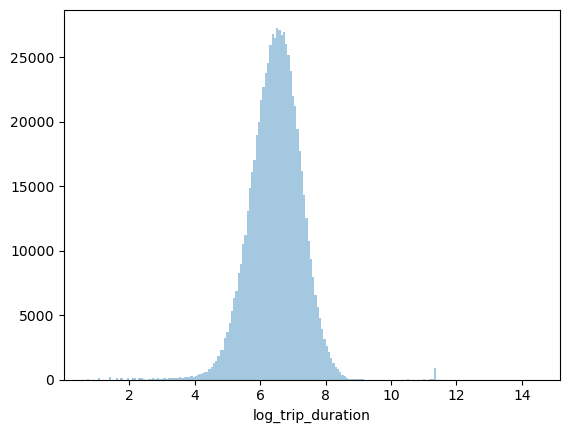

In [62]:
nyc_data['log_trip_duration'] = np.log(nyc_data['trip_duration'].values + 1)
sns.distplot(nyc_data['log_trip_duration'], kde=False, bins=200)
plt.show()

In [63]:
nyc_data['pickup_datetime'].min(), nyc_data['pickup_datetime'].max()


(Timestamp('2016-01-01 00:01:14'), Timestamp('2016-06-30 23:59:37'))

In [68]:
nyc_data['day_of_week'] = nyc_data['pickup_datetime'].dt.weekday
nyc_data['hour_of_day'] = nyc_data['pickup_datetime'].dt.hour
nyc_data


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,check_trip_duration,log_trip_duration,day_of_week,hour_of_day
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,0,400,400.0,5.993961,0,16
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,0,1100,1100.0,7.003974,4,23
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,0,1635,1635.0,7.400010,6,17
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,0,1141,1141.0,7.040536,1,9
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,0,848,848.0,6.744059,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729317,id3905982,2,2016-05-21 13:29:38,2016-05-21 13:34:34,2,-73.965919,40.789780,-73.952637,40.789181,0,296,296.0,5.693732,5,13
729318,id0102861,1,2016-02-22 00:43:11,2016-02-22 00:48:26,1,-73.996666,40.737434,-74.001320,40.731911,0,315,315.0,5.755742,0,0
729319,id0439699,1,2016-04-15 18:56:48,2016-04-15 19:08:01,1,-73.997849,40.761696,-74.001488,40.741207,0,673,673.0,6.513230,4,18
729320,id2078912,1,2016-06-19 09:50:47,2016-06-19 09:58:14,1,-74.006706,40.708244,-74.013550,40.713814,0,447,447.0,6.104793,6,9


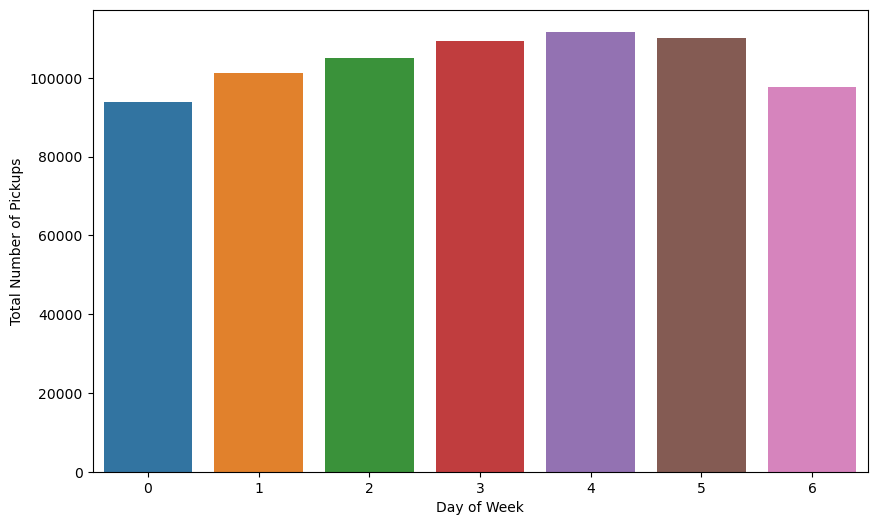

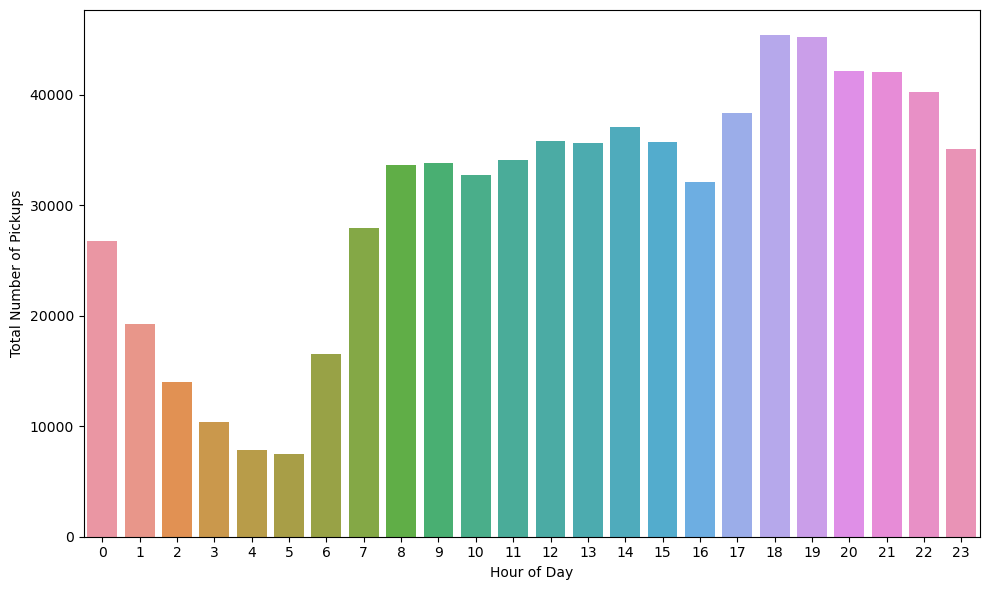

In [71]:

# Day of Week
plt.figure(figsize=(10, 6))
day_counts = nyc_data['pickup_datetime'].dt.dayofweek.value_counts().sort_index()
sns.barplot(x=day_counts.index, y=day_counts.values)
plt.xlabel('Day of Week')
plt.ylabel('Total Number of Pickups')

# Hour of Day
plt.figure(figsize=(10, 6))
hour_counts = nyc_data['pickup_datetime'].dt.hour.value_counts().sort_index()
sns.barplot(x=hour_counts.index, y=hour_counts.values)
plt.xlabel('Hour of Day')
plt.ylabel('Total Number of Pickups')

plt.tight_layout()
plt.show()

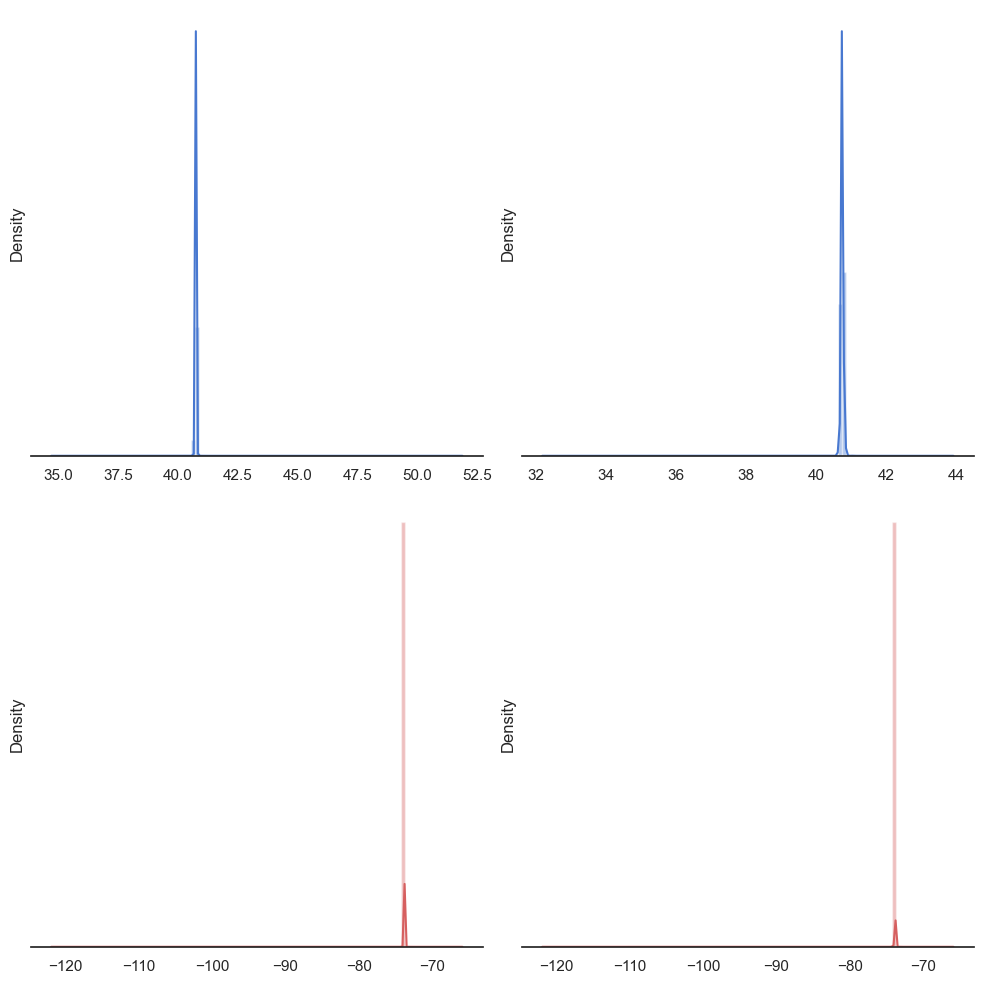

In [73]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)
sns.despine(left=True)
sns.distplot(nyc_data['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sns.distplot(nyc_data['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[1,0])
sns.distplot(nyc_data['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[0,1])
sns.distplot(nyc_data['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1,1])
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

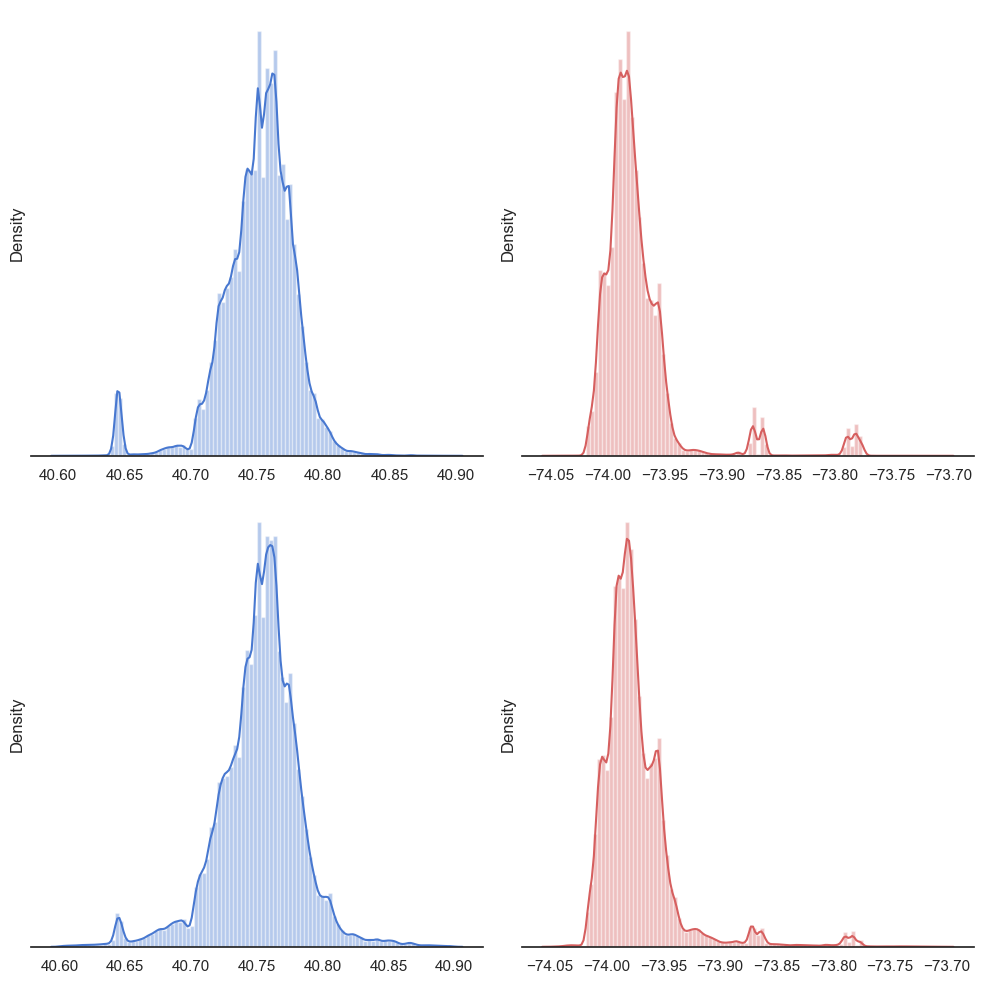

In [74]:
nyc_data = nyc_data.loc[(nyc_data.pickup_latitude > 40.6) & (nyc_data.pickup_latitude < 40.9)]
nyc_data = nyc_data.loc[(nyc_data.dropoff_latitude>40.6) & (nyc_data.dropoff_latitude < 40.9)]
nyc_data = nyc_data.loc[(nyc_data.dropoff_longitude > -74.05) & (nyc_data.dropoff_longitude < -73.7)]
nyc_data = nyc_data.loc[(nyc_data.pickup_longitude > -74.05) & (nyc_data.pickup_longitude < -73.7)]
nyc_data_data_new = nyc_data.copy()
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(10, 10), sharex=False, sharey = False)#
sns.despine(left=True)
sns.distplot(nyc_data_data_new['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sns.distplot(nyc_data_data_new['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[0,1])
sns.distplot(nyc_data_data_new['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[1, 0])
sns.distplot(nyc_data_data_new['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()

plt.show()

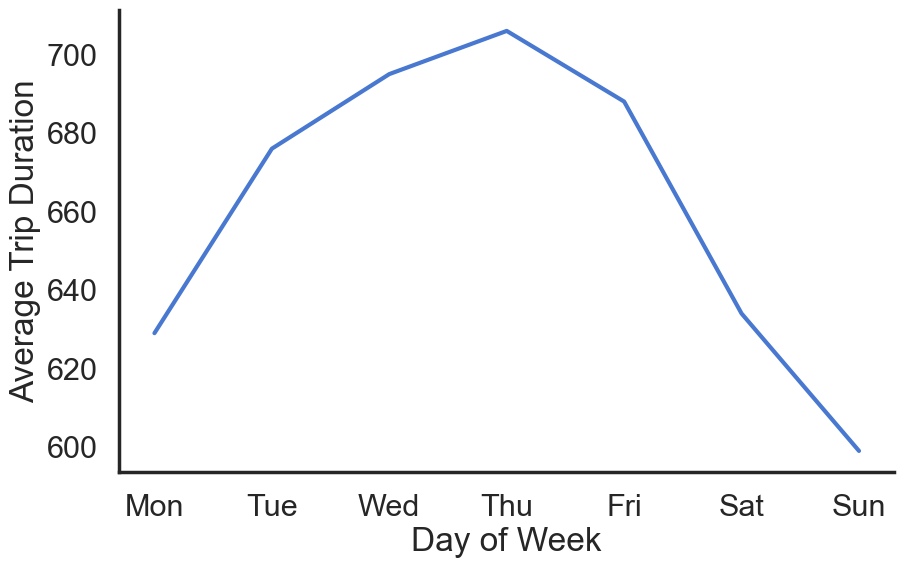

In [77]:
summary_wdays_avg_duration = nyc_data.groupby('day_of_week')['trip_duration'].median().reset_index()
summary_wdays_avg_duration['unit'] = 1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")

plt.figure(figsize=(10, 6))
sns.lineplot(data=summary_wdays_avg_duration, x="day_of_week", y="trip_duration", units="unit")

sns.despine(bottom=False)

plt.xlabel('Day of Week')
plt.ylabel('Average Trip Duration')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

plt.show()

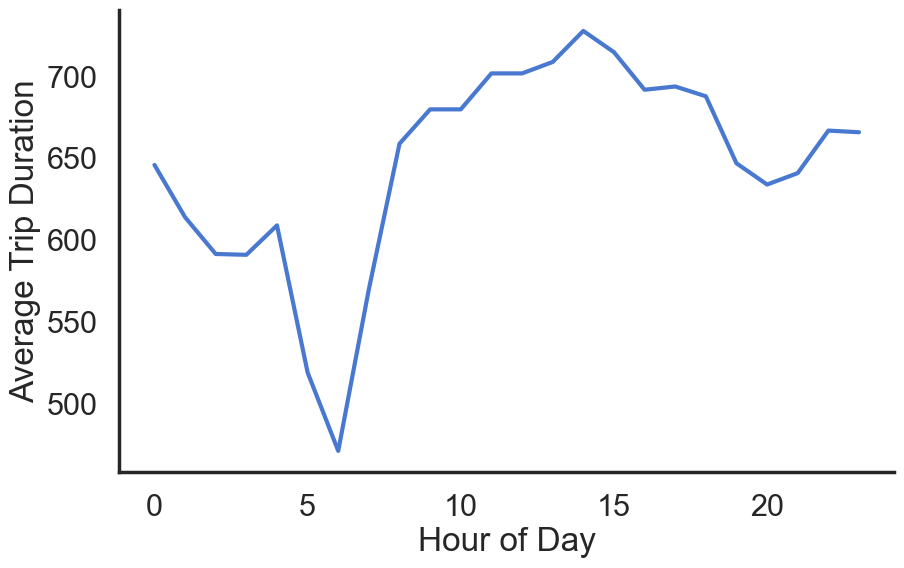

In [78]:
summary_hourly_avg_duration = nyc_data.groupby('hour_of_day')['trip_duration'].median().reset_index()
summary_hourly_avg_duration['unit'] = 1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")

plt.figure(figsize=(10, 6))
sns.lineplot(data=summary_hourly_avg_duration, x="hour_of_day", y="trip_duration")

sns.despine(bottom=False)

plt.xlabel('Hour of Day')
plt.ylabel('Average Trip Duration')

plt.show()

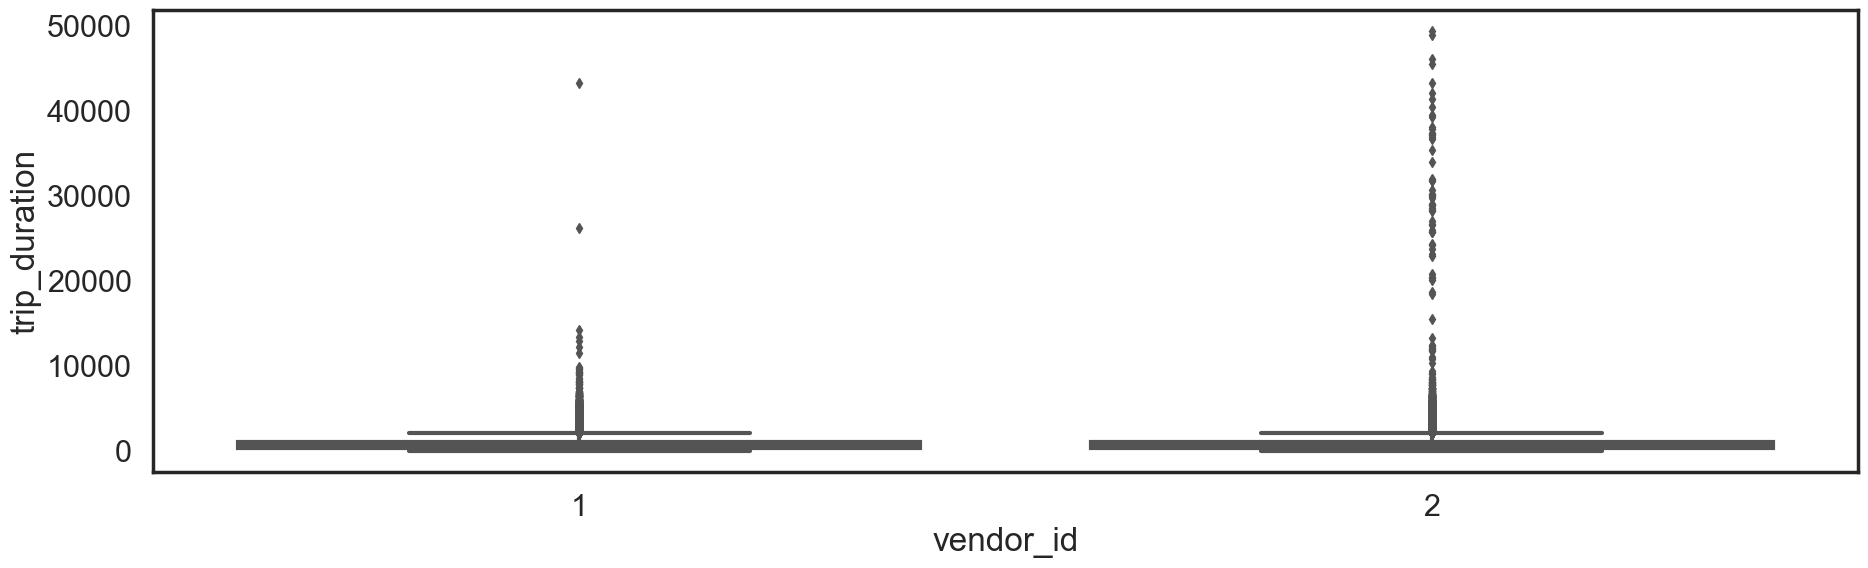

In [80]:
plt.figure(figsize=(22, 6))
nyc_data_sub = nyc_data[nyc_data['trip_duration'] < 50000]
sns.boxplot(x="vendor_id", y="trip_duration", data=nyc_data_sub)
plt.show()

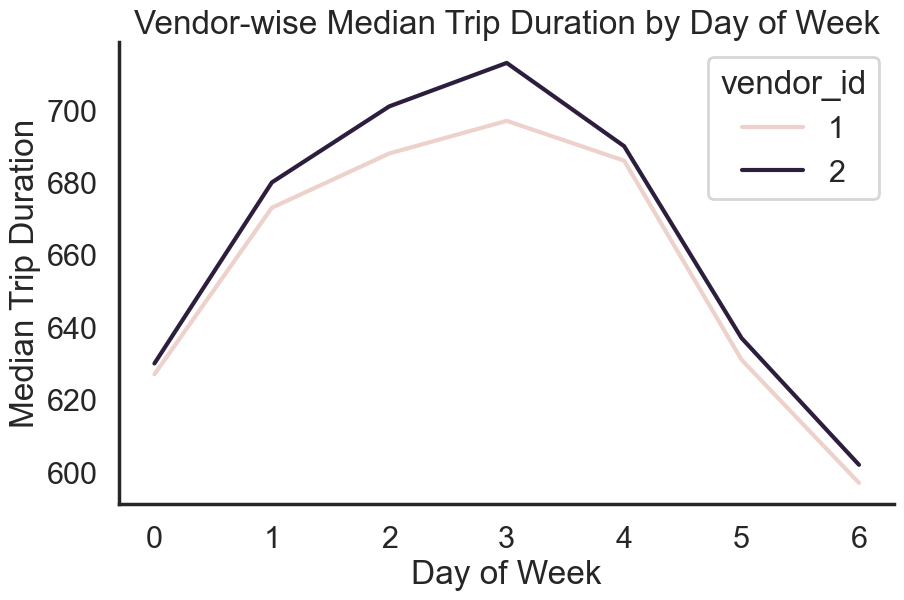

In [85]:
summary_wdays_avg_duration = nyc_data.groupby(['vendor_id', 'day_of_week'])['trip_duration'].median().reset_index()
summary_wdays_avg_duration['unit'] = 1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")

plt.figure(figsize=(10, 6))

sns.lineplot(data=summary_wdays_avg_duration, x="day_of_week", y="trip_duration", hue="vendor_id")
sns.despine(bottom=False)

plt.xlabel('Day of Week')
plt.ylabel('Median Trip Duration')
plt.title('Vendor-wise Median Trip Duration by Day of Week')

plt.show()

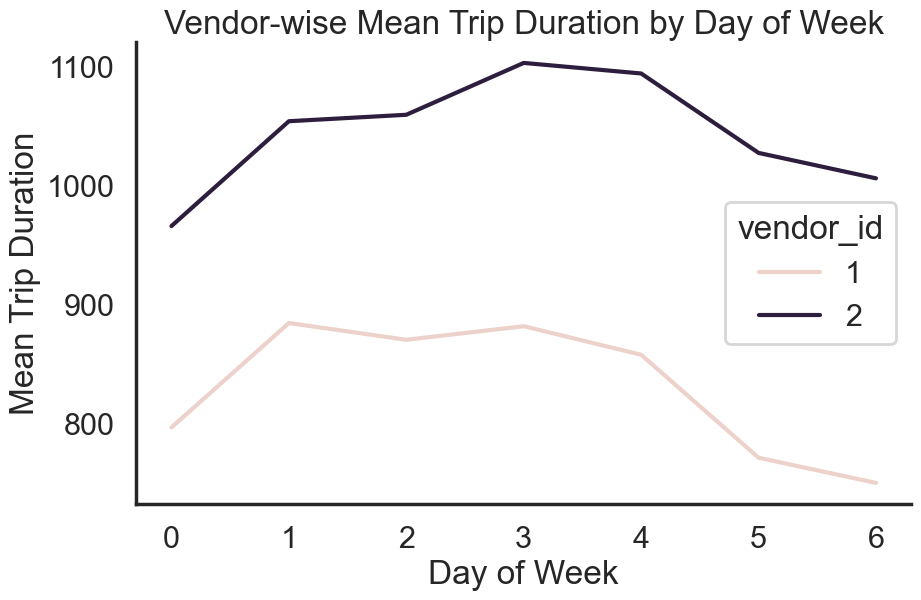

In [86]:
summary_wdays_avg_duration = nyc_data.groupby(['vendor_id', 'day_of_week'])['trip_duration'].mean().reset_index()
summary_wdays_avg_duration['unit'] = 1

sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("poster")

plt.figure(figsize=(10, 6))

sns.lineplot(data=summary_wdays_avg_duration, x="day_of_week", y="trip_duration", hue="vendor_id")
sns.despine(bottom=False)

plt.xlabel('Day of Week')
plt.ylabel('Mean Trip Duration')
plt.title('Vendor-wise Mean Trip Duration by Day of Week')

plt.show()

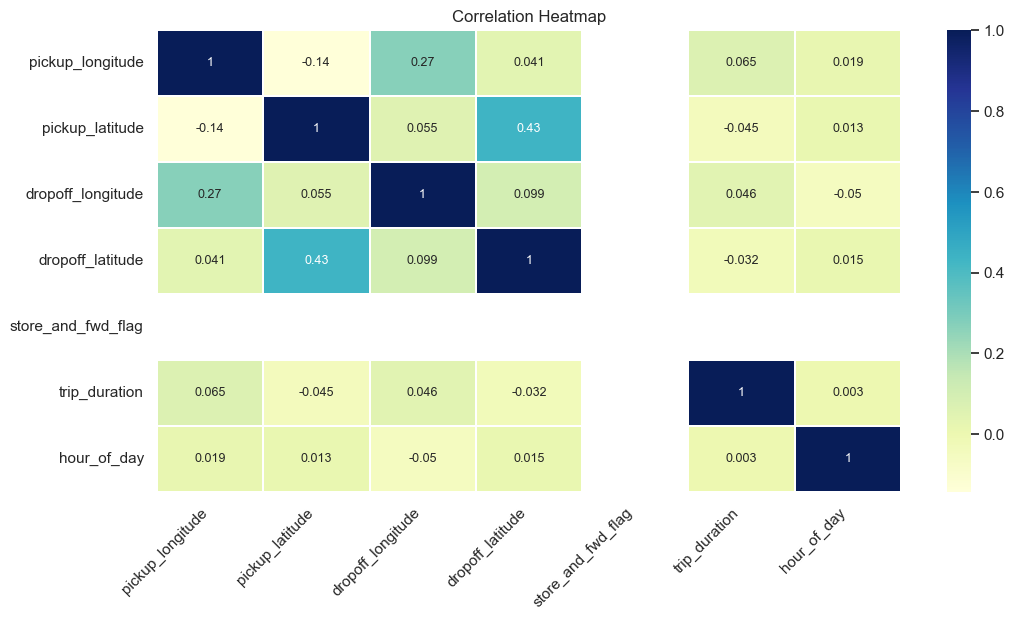

In [96]:
plt.figure(figsize=(12, 6))
nyc_data = nyc_data.drop(['vendor_id', 'day_of_week'], axis=1)  # Replace with the correct column names
corr = nyc_data.corr()

sns.set(style="white")
ax = sns.heatmap(corr, linewidths=0.2, cmap="YlGnBu", annot=True, annot_kws={"size": 9})
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('Correlation Heatmap')
plt.show()


In [100]:
nyc_data = pd.read_csv('nyc_taxi_trip_duration.csv')
nyc_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


In [101]:
nyc_data['pickup_datetime'] = pd.to_datetime(nyc_data.pickup_datetime)
nyc_data['dropoff_datetime'] = pd.to_datetime(nyc_data.dropoff_datetime)

In [102]:
df_y = np.log1p(nyc_data['trip_duration'])
nyc_data.loc[:, 'pickup_weekday'] = nyc_data['pickup_datetime'].dt.weekday
nyc_data.loc[:, 'pickup_hour_weekofyear'] = nyc_data['pickup_datetime'].dt.weekofyear
nyc_data.loc[:, 'pickup_hour'] = nyc_data['pickup_datetime'].dt.hour
nyc_data.loc[:, 'pickup_minute'] = nyc_data['pickup_datetime'].dt.minute
nyc_data.loc[:, 'pickup_dt'] = (nyc_data['pickup_datetime'] - nyc_data['pickup_datetime'].min()).dt.total_seconds()
nyc_data.loc[:, 'pickup_week_hour'] = nyc_data['pickup_weekday'] * 24 + nyc_data['pickup_hour']


In [104]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def direction_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))


nyc_data['haversine_distance'] = haversine_array(nyc_data['pickup_latitude'].values, 
                                                     nyc_data['pickup_longitude'].values, 
                                                     nyc_data['dropoff_latitude'].values, 
                                                     nyc_data['dropoff_longitude'].values)


nyc_data['direction'] = direction_array(nyc_data['pickup_latitude'].values, 
                                          nyc_data['pickup_longitude'].values, 
                                          nyc_data['dropoff_latitude'].values, 
                                          nyc_data['dropoff_longitude'].values)


In [106]:
nyc_data['pickup_latitude_round3'] = np.round(df['pickup_latitude'],3)
nyc_data['pickup_longitude_round3'] = np.round(df['pickup_longitude'],3)
nyc_data['dropoff_latitude_round3'] = np.round(df['dropoff_latitude'],3)
nyc_data['dropoff_longitude_round3'] = np.round(df['dropoff_longitude'],3)

In [107]:
nyc_data.vendor_id.value_counts()

2    390481
1    338841
Name: vendor_id, dtype: int64

In [112]:
nyc_data['vendor_id'] = nyc_data['vendor_id'] - 1

In [110]:
np.sum(pd.isnull(nyc_data))

id                          0
vendor_id                   0
pickup_datetime             0
dropoff_datetime            0
passenger_count             0
pickup_longitude            0
pickup_latitude             0
dropoff_longitude           0
dropoff_latitude            0
store_and_fwd_flag          0
trip_duration               0
pickup_weekday              0
pickup_hour_weekofyear      0
pickup_hour                 0
pickup_minute               0
pickup_dt                   0
pickup_week_hour            0
haversine_distance          0
direction                   0
pickup_latitude_round3      0
pickup_longitude_round3     0
dropoff_latitude_round3     0
dropoff_longitude_round3    0
dtype: int64

In [113]:
nyc_data.fillna(0, inplace = True)

In [116]:
xtrain, xtest, ytrain, ytest = train_test_split(df,df_y,test_size=1/3, random_state=0)

In [117]:
mean_pred = np.repeat(ytrain.mean(),len(ytest))

sqrt(mean_squared_error(ytest, mean_pred))

0.7986672307875061

In [126]:
def cv_score(ml_model, rstate=11, cols=nyc_data.columns):
    i = 1
    cv_scores = []
    df1 = nyc_data.copy()
    df1 = df1[cols]
    
    # Exclude datetime columns
    df1 = df1.select_dtypes(exclude=['datetime'])
    
    # Preprocess categorical variables
    categorical_cols = df1.select_dtypes(include=['object']).columns
    df1[categorical_cols] = df1[categorical_cols].apply(lambda x: pd.factorize(x)[0])
    
    kf = KFold(n_splits=5, random_state=rstate, shuffle=True)
    for train_index, test_index in kf.split(df1, df_y):
        print('\n{} of kfold {}'.format(i, kf.n_splits))
        xtr, xvl = df1.loc[train_index], df1.loc[test_index]
        ytr, yvl = df_y[train_index], df_y[test_index]

        model = ml_model
        model.fit(xtr, ytr)
        train_val = model.predict(xtr)
        pred_val = model.predict(xvl)
        rmse_score_train = sqrt(mean_squared_error(ytr, train_val))
        rmse_score = sqrt(mean_squared_error(yvl, pred_val))
        msg = ""
        msg += "Valid RMSE: {:.5f}".format(rmse_score)
        print("{}".format(msg))
        # Save scores
        cv_scores.append(rmse_score)
        i += 1
    return cv_scores


In [127]:
linreg_scores = cv_score(LinearRegression())


1 of kfold 5
Valid RMSE: 0.59178

2 of kfold 5
Valid RMSE: 0.59066

3 of kfold 5
Valid RMSE: 0.80265

4 of kfold 5
Valid RMSE: 0.59973

5 of kfold 5
Valid RMSE: 0.59925


In [128]:
dtree_scores = cv_score(DecisionTreeRegressor(min_samples_leaf=25, min_samples_split=25))


1 of kfold 5
Valid RMSE: 0.00483

2 of kfold 5
Valid RMSE: 0.00398

3 of kfold 5
Valid RMSE: 0.00958

4 of kfold 5
Valid RMSE: 0.00260

5 of kfold 5
Valid RMSE: 0.00256
